In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import peak_widths
from scipy.integrate import simps

%matplotlib inline

Подгружаем данные

In [32]:
df = pd.read_csv('data\ExpDat_SK_Clear_resin_entalp5kpm_20-150.txt', sep='\t',comment='#')
df.columns = ['Temp', 'Time', 'DSC', 'Sence']

df.head()

,Temp,Time,DSC,Sence
0,20.01794,0.01,0.022839,3.36733
1,20.01857,0.02,0.022820,3.36733
2,20.02401,0.03,0.022770,3.36734
3,20.03631,0.04,0.022824,3.36735
4,20.05572,0.05,0.023849,3.36737


Text(0.5, 1.0, 'Raw cure kinetics signal')

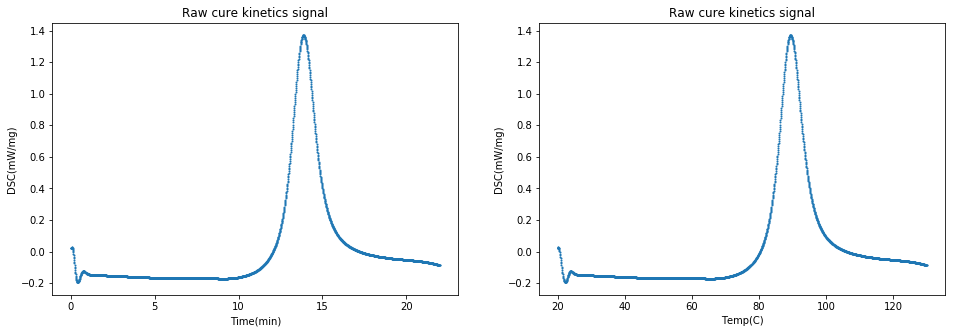

In [33]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))

ax[0].set_xlabel("Time(min)")
ax[0].set_ylabel('DSC(mW/mg)')
ax[0].plot(df['Time'], df['DSC'], "o", markersize=1)
ax[0].set_title('Raw cure kinetics signal')

ax[1].set_xlabel("Temp(C)")
ax[1].set_ylabel('DSC(mW/mg)')
ax[1].plot(df['Temp'], df['DSC'], "o", markersize=1)
ax[1].set_title('Raw cure kinetics signal')

Давай по искать точки начала и конца пика по температуре - так будет удобнее. На этом графике он будет где-то от 60 до 110. Вообще отделюную часть кода нужно уделить определению точек начала и конца. Я пытался сделать это автоматически красиво, но получилось так себе. Наверное лучше составить отдельную таблицу и захардкодить.

[0.27778, 0.28154]


Text(0.5, 1.0, 'Raw cure kinetics signal')

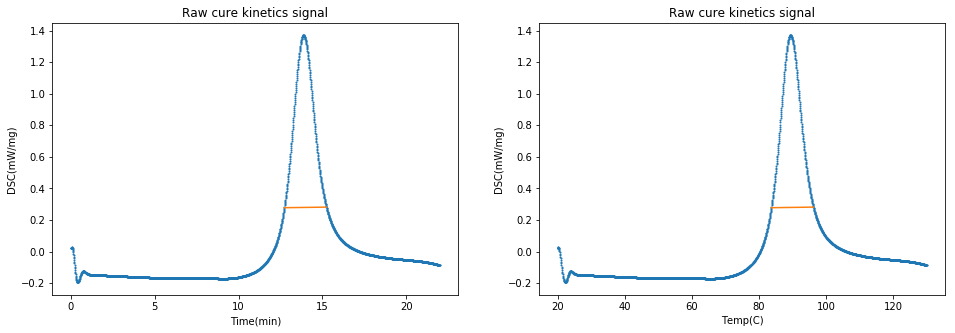

In [39]:
peaks_positive, _ = find_peaks(df['DSC'], height=1.2)
peaks_width, width_heights, _, _ = peak_widths(df['DSC'], peaks_positive, rel_height = 0.75)

peak_start = df['DSC'][df['DSC']>0.27737123].first_valid_index()
peak_end = df['DSC'][df['DSC']>0.27737123].last_valid_index()


print([df['DSC'][peak_start],df['DSC'][peak_end]])

fig, ax = plt.subplots(1, 2, figsize = (16, 5))


ax[0].plot(df['Time'], df['DSC'], "o", markersize=1, label = "Signal")
ax[0].plot([df['Time'][peak_start],df['Time'][peak_end]],
               [df['DSC'][peak_start],df['DSC'][peak_end]],
              label = "Baseline")
ax[0].set_xlabel("Time(min)")
ax[0].set_ylabel('DSC(mW/mg)')
ax[0].set_title('Raw cure kinetics signal')

ax[1].plot(df['Temp'], df['DSC'], "o", markersize=1, label = "Signal")
ax[1].plot([df['Temp'][peak_start],df['Temp'][peak_end]],
               [df['DSC'][peak_start],df['DSC'][peak_end]],
                label = "Baseline")
ax[1].set_xlabel("Temp(C)")
ax[1].set_ylabel('DSC(mW/mg)')
ax[1].set_title('Raw cure kinetics signal')

#TODO add legend on plots

Режем пик по точкам начала и конца, приводим к бейслайну

Дальше режем данные и оставляем только пик, приведенный к бэйслайну. И уже по приведенному к бейслайну пику строим альфу - степень полимеризации

In [35]:
peak = df.iloc[peak_start:peak_end]

spent_energy = simps(peak)

print(spent_energy)


[50.33607    50.37541833 50.41495167 50.45420833 50.4937725  50.53373167
 50.5735275  50.61351    50.65357083 50.6937925  50.73411917 50.77473417
 50.81527583 50.85609917 50.897185   50.93833583 50.97935833 51.02062333
 51.0620125  51.10369833 51.14556    51.18737333 51.22958417 51.27186917
 51.31420167 51.35673667 51.39930833 51.44215083 51.48515167 51.52816167
 51.5712225  51.61452583 51.65809583 51.701835   51.74565917 51.78936833
 51.83321583 51.8776025  51.92197417 51.96629167 52.01093333 52.05567583
 52.1003575  52.145265   52.1903725  52.2353675  52.28044667 52.32561083
 52.37089    52.41634417 52.46198    52.50772417 52.55357667 52.59924083
 52.64484417 52.69041917 52.7362175  52.78216083 52.82788333 52.87376583
 52.9198625  52.96568083 53.01145833 53.05724667 53.10313917 53.14887083
 53.19472583 53.24032333 53.28593083 53.33147583 53.37660167 53.42182167
 53.4671825  53.51235    53.5572775  53.60186917 53.6464875  53.69081083
 53.73510417 53.77887917 53.82268333 53.86652    53